In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

from datetime import datetime, timedelta

from pykalman import KalmanFilter
from math import sqrt
from numba import njit, vectorize, typeof, types

# check how much of historical orderbook can be gotten
# entering into position slippage can be simulated here
# np.array([], dtype="float64")
# np.array([], dtype="float64")

In [109]:
# @njit(types.Array(types.float64, 1, 'C')(types.Array(types.float64, 1, 'C'), types.Array(types.float64, 1, 'C'), types.float64, types.float64))
@njit

def Kalman_regression(series1, series2, delta=1e-4, R=1e-3):
  R_init = R
  Q_init = delta / (1-delta) * np.eye(2)
  x_init = np.zeros((2, 1))
  P_init = np.ones((2,2))
  
  # def step_forward(y1, y2):
  #   # Before entering the equations, let's define H as (1, 2) matrix
  #   H = np.array([y2, 1])[None]
  #   # and define z
  #   z = y1

  #   ## TIME UPDATE ##
  #   # first thing is to predict new state as the previous one (2x1)
  #   x_hat = x_init[:, -1][..., None]

  #   # then, the uncertainty or covariance prediction 
  #   P_hat = P_init + Q_init

  #   ## MEASUREMENT UPDATE ##
  #   # calc the Kalman gain
  #   K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+R)

  #   # state update part 1 (measurement estimation)
  #   z_hat = H.dot(x_hat)
  #   # state update part 2
  #   x = x_hat + K.dot(z-z_hat)

  #   # uncertainty update
  #   P_init = (np.eye(2)-K.dot(H)).dot(P_hat)

  #   # append the new state to the vector
  #   x_init = np.concatenate([x, x], axis=1)

  #   return x
  
  
  state_means = np.zeros((0, 2))
  
  for t in range(0, series1.shape[0]):
      # x_step = step_forward(series1[t], series2[t])
      H = np.array([series2[t], 1])[None]
      # and define z
      z = series1[t]

      ## TIME UPDATE ##
      # first thing is to predict new state as the previous one (2x1)
      x_hat = x_init[:, -1][..., None]

      # then, the uncertainty or covariance prediction 
      P_hat = P_init + Q_init

      ## MEASUREMENT UPDATE ##
      # calc the Kalman gain
      K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+R)

      # state update part 1 (measurement estimation)
      z_hat = H.dot(x_hat)
      # state update part 2
      x = x_hat + K.dot(z-z_hat)

      # uncertainty update
      P_init = (np.eye(2)-K.dot(H)).dot(P_hat)

      # append the new state to the vector
      x_init = np.concatenate([x_init, x], axis=1)
      state_means = np.vstack((state_means, [x_init[0][0], x_init[1][0]]))
      
  hedge_ratio = - state_means[:,0]
  spread = series1 + (series2 * hedge_ratio)
  
  return spread

In [110]:
res = Kalman_regression(series1=np.array([0.28, 0.21, 0.3]), series2=np.array([0.38, 0.31, 0.4]), delta=1e-4, R=1e-3)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 1d, C), none)
 
There are 22 candidate implementations:
      - Of which 20 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(array(float64, 1d, C), none)':
       No match.
      - Of which 2 did not match due to:
      Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 166.
        With argument(s): '(array(float64, 1d, C), none)':
       Rejected as the implementation raised a specific error:
         NumbaTypeError: unsupported array index type none in [none]
  raised from /Users/mscbr/opt/anaconda3/envs/trader_env/lib/python3.8/site-packages/numba/core/typing/arraydecl.py:72

During: typing of intrinsic-call at /var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_23521/2184617172.py (45)
During: typing of static-get-item at /var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_23521/2184617172.py (45)

File "../../../../../../../var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_23521/2184617172.py", line 45:
<source missing, REPL/exec in use?>


In [95]:
typeof(res)

array(float64, 1d, C)

In [96]:
typeof(np.array([0.28, 0.21, 0.3]))

array(float64, 1d, C)

In [97]:
typeof(1e-4)

float64

In [114]:
# rewrite this to def & then to numba
class MyKalmanFilter:
    
  def __init__(self, delta=1e-4, R=1e-3):
    # measurement noise variance
    self.R = R

    # co-variance of process noise(2 dimensions)
    self.Q = delta / (1-delta) * np.eye(2)

    # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
    self.x = np.zeros((2, 1))     

    # state covariance
    self.P = np.ones((2,2))     

  def step_forward(self, y1, y2):
    # Before entering the equations, let's define H as (1, 2) matrix
    H = np.array([y2, 1])[None]
    # and define z
    z = y1

    ## TIME UPDATE ##
    # first thing is to predict new state as the previous one (2x1)
    x_hat = self.x[:, -1][..., None]

    # then, the uncertainty or covariance prediction 
    P_hat = self.P + self.Q

    ## MEASUREMENT UPDATE ##
    # calc the Kalman gain
    K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

    # state update part 1 (measurement estimation)
    z_hat = H.dot(x_hat)
    # state update part 2
    x = x_hat + K.dot(z-z_hat)

    # uncertainty update
    self.P = (np.eye(2)-K.dot(H)).dot(P_hat)

    # append the new state to the vector
    self.x = np.concatenate([self.x, x], axis=1)

    return x
  
  def regression(self, series1, series2):
    state_means = np.zeros((0, 2), dtype="float64")
    
    for t in range(0, series1.shape[0]):
        x = self.step_forward(series1[t], series2[t])
        state_means = np.vstack((state_means, [x[0][0], x[1][0]]))
        
    hedge_ratio = - state_means[:,0]
    spread = series1 + (series2 * hedge_ratio)
    
    return spread
  
def get_current_zscore(series, rolling_window=None):
  if rolling_window is not None:
    # this windows definitely could be optimized or sth
    spread_mean = series.rolling(center=False, window=rolling_window).mean()
    spread_std = series.rolling(center=False, window=rolling_window).std()
    z_score_series = (series-spread_mean)/spread_std
  else:  
    z_score_series = (series-series.mean())/series.std()
    
  return z_score_series[-1], z_score_series

def get_Kalman_spread(series1, series2):
  # return series1/series2
  mkf = MyKalmanFilter(delta=1e-4, R=2)
  spread = mkf.regression(series1, series2)
  
  return spread

In [60]:
inst1 = "AUDIOUSDT_FUTURES"
inst2 = "FTMUSDT_FUTURES"
pair = [inst1,inst2]
ticker_interval = "15m"
raw_data_dir="./raw_data/Binance_Historical_15m_FUTURES_20_days_2022-07-14T12:00:43"
tc=0.0006

def _get_data():
    entries = []
    for instrument in pair:
      entries.append("%s_%s.csv" % (instrument, ticker_interval))
    # removing duplicates
    entries = list(set(entries))
      
    df_closings = pd.DataFrame()
    for entry in entries:
      instrument = "_".join(entry.split("_")[0:-1])
      df = pd.read_csv('%s/%s' % (raw_data_dir, entry), index_col="Date", parse_dates=["Date"])
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df["%s_returns" % instrument] = df[instrument]/df[instrument].shift(1)
      df_closings = pd.concat([df_closings, df], axis=1)
      
    df_closings.dropna(inplace=True)
    df_closings = df_closings.T.drop_duplicates().T
    # data = df_closings
    # tp_year = (data.shape[0] / ((data.index[-1] - data.index[0]).days / 365.25))
    return df_closings
    
    # # wholesample for charting purposes
    # state_means = KalmanFilterRegression(df_closings[pair[0]], df_closings[pair[1]])
      
    # hr = - state_means[:, 0]
    # spread = df_closings[pair[1]] + (df_closings[pair[0]]* hr)
    # chart_spread = spread
raw_data = _get_data()

series1 = raw_data[inst1].to_numpy()
series2 = raw_data[inst2].to_numpy()
returns1 = raw_data["%s_returns" % inst1].to_numpy()
returns2 = raw_data["%s_returns" % inst2].to_numpy()

In [ ]:
# series1 = np.array([0.3856, 0.3821, 0.3828, 0.3838, 0.385 , 0.3817, 0.386 , 0.383 ,
#        0.3749, 0.374 , 0.3694, 0.3696])
# series2 = np.array([0.2843, 0.2819, 0.2816, 0.2854, 0.2874, 0.2842, 0.2849, 0.284 ,
#        0.2802, 0.2799, 0.2756, 0.2765])
# returns1 = np.array([0.9984464 , 0.99092324, 1.00183198, 1.00261233, 1.00312663,
#        0.99142857, 1.01126539, 0.99222798, 0.97885117, 0.99759936,
#        0.98770053, 1.00054142])
# returns2 = np.array([0.99859501, 0.99155821, 0.99893579, 1.01349432, 1.00700771,
#        0.98886569, 1.00246305, 0.996841  , 0.98661972, 0.99892934,
#        0.98463737, 1.0032656 ])

In [112]:
def backtest_pair(
    window=48,
    z_long_perc=5,
    z_short_perc=95,
    tp=0.01,
    sl=-0.01,
    avg_kalman=False,
    rolling_z_window=None,
    silent=False,
    start_date=None,
    vanilla_Kalman=False
    ):
    
    # param_str = "w_{}_p_{}_{}_sltp_{}_{}".format(
    #   window, z_long_perc, z_short_perc, str(sl).replace(".", "d"), str(tp).replace(".", "d"))
    # series1 = np.array([0.3856, 0.3821, 0.3828, 0.3838, 0.385 , 0.3817, 0.386 , 0.383 ,
    #    0.3749, 0.374 , 0.3694, 0.3696])
    # series2 = np.array([0.2843, 0.2819, 0.2816, 0.2854, 0.2874, 0.2842, 0.2849, 0.284 ,
    #       0.2802, 0.2799, 0.2756, 0.2765])
    # returns1 = np.array([0.9984464 , 0.99092324, 1.00183198, 1.00261233, 1.00312663,
    #       0.99142857, 1.01126539, 0.99222798, 0.97885117, 0.99759936,
    #       0.98770053, 1.00054142])
    # returns2 = np.array([0.99859501, 0.99155821, 0.99893579, 1.01349432, 1.00700771,
    #       0.98886569, 1.00246305, 0.996841  , 0.98661972, 0.99892934,
    #       0.98463737, 1.0032656 ])
    
    inst1 = pair[0]
    inst2 = pair[1]
    # data = raw_data.copy()
    
    signals = np.empty((0, 1), dtype="float64")
    inst1_position = np.empty((0, 1), dtype="float64")
    inst2_position = np.empty((0, 1), dtype="float64")
    spread_record = np.empty((0, 1), dtype="float64")
    zscore = np.empty((0, 1), dtype="float64")
    z_long_record = np.empty((0, 1), dtype="float64")
    z_short_record = np.empty((0, 1), dtype="float64")
    gross_returns = np.empty((0, 1), dtype="float64")
    net_returns = np.empty((0, 1), dtype="float64")
    
    signal = 0
    old_signal = 0
    current_return = 0
    position1 = 0
    position2 = 0
    
    iter_start = window
    # if start_date is not None: 
    #   try:
    #     iter_start = data.index.get_loc(start_date)
    #   except:
    #     print("Couldn't find start_date: %s" % start_date)
    
    # moving through the sample
    for t in range(iter_start, series1.shape[0]-1):
      # because of sampling index is off when sample[t]
      # sample = data.iloc[t-window:t+2].copy()
      sample_series1 = series1[t-window:t+2]
      sample_series2 = series2[t-window:t+2]

      old_signal = signal
      old_position1 = position1
      old_position2 = position2
      gross = 0
      net = 0
      
      # spread = get_Kalman_spread(sample_series1, sample_series2)
      mkf = MyKalmanFilter(delta=1e-4, R=2)
      spread = mkf.regression(sample_series1, sample_series2)
      # spread = Kalman_regression(sample_series1, sample_series2, delta=1e-4, R=2)
      # spread = jitted_Kalman_regression(sample_series1, sample_series2, delta=1e-4, R=2)
      
      # spread = sample_series1/sample_series2
      # current_z_score, z_score_series = get_current_zscore(spread, rolling_window=rolling_z_window)
      # spread = sample_series1/sample_series2
      z_score_series = (spread-spread.mean())/spread.std()
      current_z_score = z_score_series[-1]
      
      z_percentiles = np.percentile(z_score_series, [z_long_perc, z_short_perc])
      z_long = z_percentiles[0]
      z_short = z_percentiles[1]
      
      if old_signal == 0:
        if current_z_score < z_long: 
          signal = 1
        elif current_z_score > z_short: 
          signal = -1
      elif old_signal != 0:
        if current_return >= tp:
          signal = 0
        elif current_return <= sl:
          signal = 0
        
      position1 = -signal
      position2 = signal

      # check out what type of index is within the sample & if usage of "window+1" is legit
      gross = position1*returns1[t+1] + position2*returns2[t+1]
      # position1*sample["%s_returns" % inst1][window+1] + position2*sample["%s_returns" % inst2][window+1]
      net = gross - tc*(abs(position1 - old_position1) + abs(position2 - old_position2))
      if signal == old_signal:
        current_return = (1+current_return)*(1+net)-1
        # current_return = current_return + np.exp(net) # logs should be additive
      else:
        current_return = net
        # current_return = np.exp(net)

      inst1_position = np.vstack((inst1_position, [position1]))
      inst2_position = np.vstack((inst2_position, [position2]))
      signals = np.vstack((signals, [signal]))
      spread_record = np.vstack((spread_record, [spread[-1]])) # double-check on this
      zscore = np.vstack((zscore, [current_z_score]))
      z_long_record = np.vstack((z_long_record, [z_long]))
      z_short_record = np.vstack((z_short_record, [z_short]))
      gross_returns = np.vstack((gross_returns, [gross]))
      net_returns = np.vstack((net_returns, [net]))
      # data.loc[[data.index[t]], ["%s_position" % inst1]] = position1
      # data.loc[[data.index[t]], ["%s_position" % inst2]] = position2
      # data.loc[[data.index[t]], ["signals"]] = signal
      # data.loc[[data.index[t]], ["gross_returns"] ] = gross
      # data.loc[[data.index[t]], ["net_returns"]] = net
      # data.loc[[data.index[t]], ["zscore"]] = current_z_score
      # data.loc[[data.index[t]], ["z_long"]] = z_long
      # data.loc[[data.index[t]], ["z_short"]] = z_short
      # data.loc[[data.index[t]], ["spread"]] = spread.iloc[-1]
      

      # interface: reporting daily positions and realised returns
      # if silent is True:
      #   continue
      
      # # current stats
      # print('\033[1m \033[37m', 100 * "=")
      # if signal == 1:
      #   print('LONG: ',inst2,' SHORT: ',inst1, " z-score entry", z_long)
      # elif signal == -1:
      #   print('LONG: ',inst1,' SHORT: ',inst2, " z-score entry", z_short)
      # cum_net = round(np.prod(1+data["net_returns"])*100-100, 2)
      # print(
      #   "\033[0m",
      #   str(data.index[t]), t, "/", len(data)-1,
      #   " \033%sCUM RET:" % get_pos_neg_color(cum_net), str(cum_net) + '% ',
      #   "\033%sCURENT NET:" % get_pos_neg_color(current_return), str(round(current_return, 3))+ '% ',
      #   "\033%sPOS:" % get_pos_neg_color(signal), signal
        # )
      
    gross_cum = np.reshape(np.cumprod(1+gross_returns), (-1, 1))
    net_cum = np.reshape(np.cumprod(1+net_returns), (-1, 1))
    
    output = np.concatenate((
      inst1_position,
      inst2_position,
      signals,
      spread_record,
      zscore,
      z_long_record,
      z_short_record,
      gross_returns,
      net_returns,
      gross_cum,
      net_cum,
    ), axis=1)
    
    return output
    

In [113]:
results = backtest_pair(window=300,
    z_long_perc=3,
    z_short_perc=97,
    tp=0.03,
    sl=-0.12,
    avg_kalman=False,
    rolling_z_window=None,
    silent=True,
    vanilla_Kalman=True)

In [29]:
df = pd.DataFrame(results, columns=["pos1", "pos2", "signals", "spread", "zscore", "z_long", "z_short", "gross", "net", "gross_cum", "net_cum"])

KeyError: -1

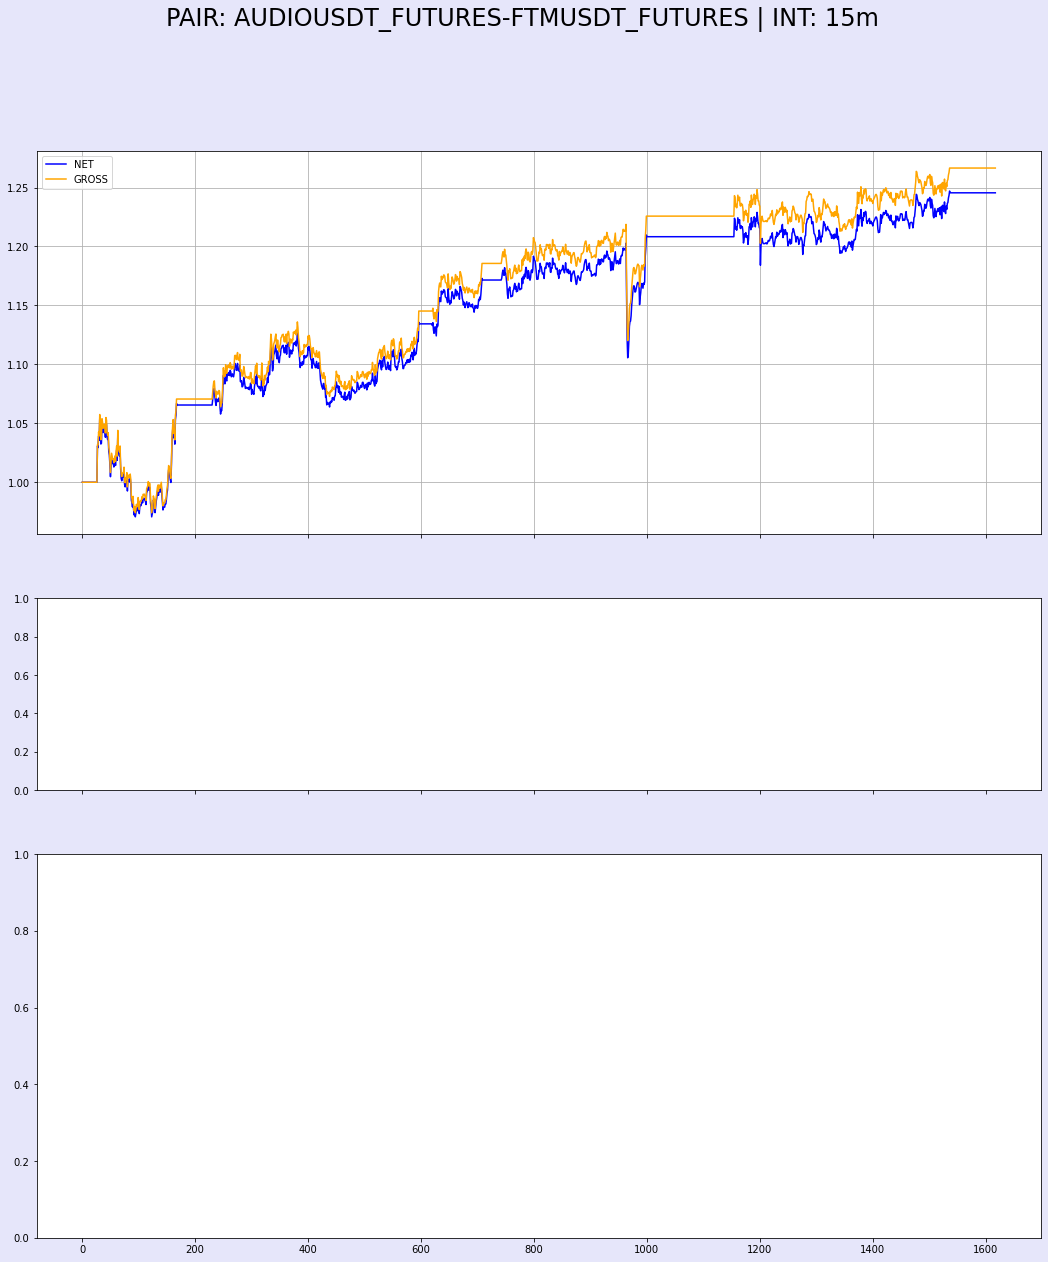

In [30]:
result = df.copy()
fig, axs = plt.subplots(
  3, 1, gridspec_kw={'height_ratios': [2, 1, 2]}, 
  sharex=True, figsize=(18, 20))
fig.patch.set_facecolor('lavender')
fig.suptitle("PAIR: %s | INT: %s" % (inst1+"-"+inst2, "15m"), fontsize=24)

axs[0].plot(result["net_cum"], color="blue", label="NET")
axs[0].plot(result["gross_cum"], color="orange", label="GROSS")
axs[0].grid()
axs[0].legend()
axs[0].set_xlabel("PNL | NET: {}%".format(round((result.net_cum[-1] - 1)*100, 2)), fontsize=22)

axs[1].plot(result["zscore"], color="black", label="ZSCORE")
axs[1].plot(result["z_long"], color="green", label="ZLONG")
axs[1].plot(result["z_short"], color="red", label="ZSHORT")
axs[1].grid()
axs[1].legend()
axs[1].set_xlabel("ENTRIES", fontsize=22)

spread = result["spread"]
long = spread.copy()
short = spread.copy()
long[result.signals!=1] = np.NaN
short[result.signals!=-1] = np.NaN
axs[2].plot(spread, color="slategrey", label="SPREAD")
axs[2].plot(long, color="green", label="LONG")
axs[2].plot(short, color="red", label="SHORT")
axs[2].grid()
axs[2].legend()
axs[2].set_xlabel("POSITIONS", fontsize=22)
plt.show()

In [34]:
jitted_backtest = jit()(backtest_pair)

In [35]:
%time _ = jitted_backtest(window=300,z_long_perc=3,z_short_perc=97,tp=0.03,sl=-0.12,avg_kalman=False,rolling_z_window=None,silent=True,vanilla_Kalman=True)

/var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_62012/3776867654.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "backtest_pair" failed type inference due to: Untyped global name 'raw_data': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "../../../../../../../var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_62012/3776867654.py", line 19:
<source missing, REPL/exec in use?>

  def backtest_pair(
/var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_62012/3776867654.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "backtest_pair" failed type inference due to: Untyped global name 'raw_data': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "../../../../../../../var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_62012/3776867654.py", line 19:
<source missing, REPL/exec in use?>

  def back

CPU times: user 27 s, sys: 115 ms, total: 27.1 s
Wall time: 27.2 s
